### Setup


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from etna.datasets import TSDataset
from etna.models import NaiveModel, CatBoostPerSegmentModel
from etna.metrics import SMAPE
from etna.analysis import plot_forecast
from etna.transforms import LagTransform, LogTransform
from etna.pipeline import Pipeline

import warnings
from IPython.display import clear_output

plt.rcParams["figure.figsize"] = (10, 4)
warnings.filterwarnings("ignore")
clear_output()

### Creating TSDataset


In [2]:
df_origin = pd.read_csv(
    "../data/taxi.csv", parse_dates=["datetime"], index_col="datetime")
df_origin.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# resample the data to 1 hour interval
df_origin = df_origin.resample("1H").sum()
df_origin.reset_index(inplace=True)

In [4]:
df_origin["timestamp"] = pd.to_datetime(df_origin["datetime"])
df_origin["target"] = df_origin["num_orders"]
df_origin = df_origin[["timestamp", "target"]]
df_origin["segment"] = "main"

df_origin.head()

,timestamp,target,segment
0,2018-03-01 00:00:00,124,main
1,2018-03-01 01:00:00,85,main
2,2018-03-01 02:00:00,71,main
3,2018-03-01 03:00:00,66,main
4,2018-03-01 04:00:00,43,main


In [8]:
df_origin.to_csv("../apps/draft_app/data/taxi_hour.csv", index=False)

In [ ]:
df_origin = pd.read_csv(
    "../data/taxi.csv", parse_dates=["datetime"], index_col="datetime")
df_origin.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
# resample the data to 1 hour interval
df_origin = df_origin.resample("1H").sum()
df_origin.reset_index(inplace=True)

In [ ]:
df_origin["timestamp"] = pd.to_datetime(df_origin["datetime"])
df_origin["target"] = df_origin["num_orders"]
df_origin = df_origin[["timestamp", "target"]]
df_origin["segment"] = "main"

df_origin.head()

,timestamp,target,segment
0,2018-03-01 00:00:00,124,main
1,2018-03-01 01:00:00,85,main
2,2018-03-01 02:00:00,71,main
3,2018-03-01 03:00:00,66,main
4,2018-03-01 04:00:00,43,main


In [6]:
df = TSDataset.to_dataset(df_origin)
df.head()

segment,main
feature,target
timestamp,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
pd.read_csv("../apps/draft_app/data/taxi_hour.csv")

,timestamp,target,segment
0,2018-03-01 00:00:00,124,main
1,2018-03-01 01:00:00,85,main
2,2018-03-01 02:00:00,71,main
3,2018-03-01 03:00:00,66,main
4,2018-03-01 04:00:00,43,main
...,...,...,...
4411,2018-08-31 19:00:00,136,main
4412,2018-08-31 20:00:00,154,main
4413,2018-08-31 21:00:00,159,main
4414,2018-08-31 22:00:00,223,main


In [6]:
ts = TSDataset(df, freq="1H")
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: 1H
         start_timestamp       end_timestamp  length  num_missing
segments                                                         
main          2018-03-01 2018-08-31 23:00:00    4416            0


In [7]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2018-03-01,2018-08-31 23:00:00,4416,0,1,0,0,0,1H


### Plotting


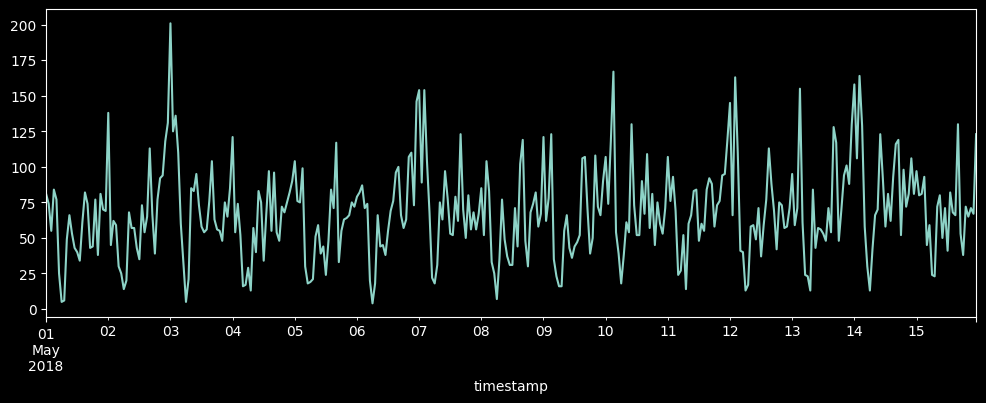

In [8]:
# take a two weeks slice to plot
ts["2018-05-01":"2018-05-15", "main", "target"].plot(figsize=(12, 4))
plt.show()

### Forecasting single time series


In [9]:
# take only one month for now
ts = TSDataset(ts["2018-05-01":"2018-05-31"], freq="1H")

train_ts, test_ts = ts.train_test_split(
    train_start="2018-05-01",
    train_end="2018-05-30",
    test_start="2018-05-31",
    test_end="2018-05-31"
)

In [10]:
test_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: 1H
         start_timestamp       end_timestamp  length  num_missing
segments                                                         
main          2018-05-31 2018-05-31 23:00:00      24            0


In [11]:
HORIZON = 24

model = NaiveModel(lag=24)
model.fit(train_ts)

future_ts = train_ts.make_future(
    future_steps=HORIZON, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)

In [12]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 30.31525571482347}

Symmetric mean absolute percentage error — $30\%$


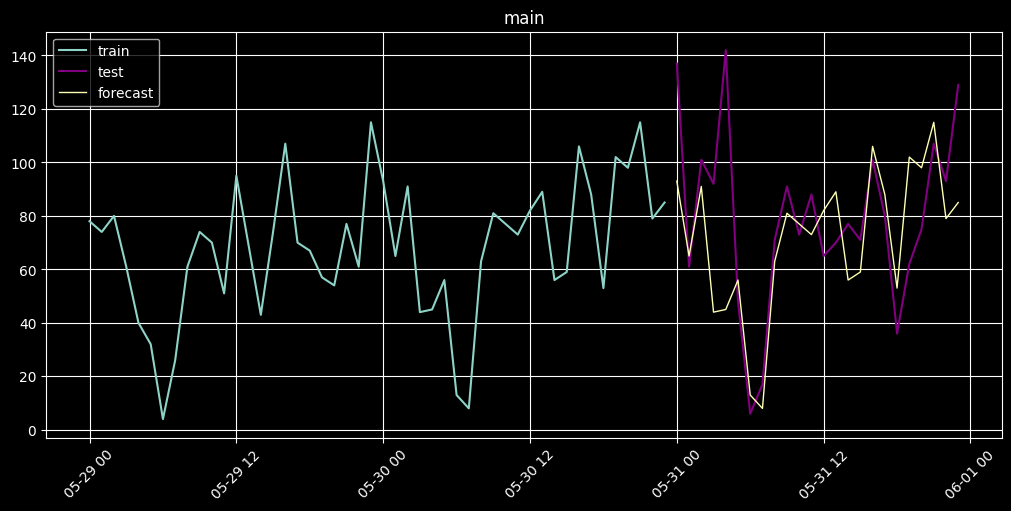

In [13]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=HORIZON*2)

### CatBoost


In [14]:
transforms = [
    LagTransform(in_column="target", lags=[HORIZON * i for i in range(1, 6)]),
    LogTransform(in_column="target")
]

train_ts.fit_transform(transforms)

model = CatBoostPerSegmentModel()
model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)
forecast_ts = model.forecast(future_ts)
forecast_ts.inverse_transform(transforms)

In [15]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 16.64918310755429}

The score has improved 2 times.


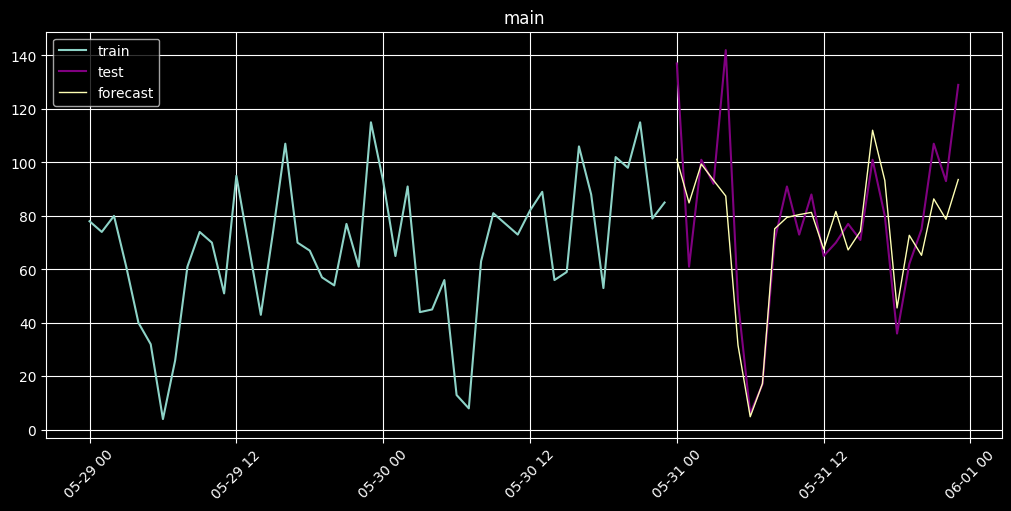

In [16]:
train_ts.inverse_transform(transforms)
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=HORIZON*2)

### Pipeline


In [17]:
# take only one month for now
ts = TSDataset(ts["2018-05-01":"2018-05-31"], freq="1H")

train_ts, test_ts = ts.train_test_split(
    train_start="2018-05-01",
    train_end="2018-05-30",
    test_start="2018-05-31",
    test_end="2018-05-31"
)

In [18]:
HORIZON = 24

transforms = [
    LagTransform(in_column="target", lags=[HORIZON * i for i in range(1, 6)]),
    LogTransform(in_column="target")
]

In [19]:
model = Pipeline(
    model=CatBoostPerSegmentModel(),
    transforms=transforms,
    horizon=HORIZON,
)

model.fit(train_ts)
forecast_ts = model.forecast()

In [20]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 16.64918310755429}

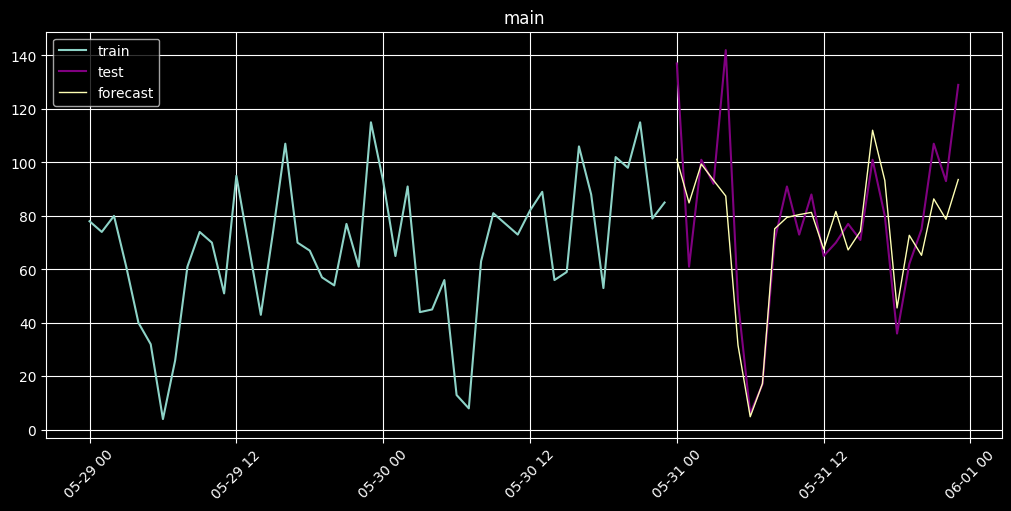

In [21]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=HORIZON*2)